In [9]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [13]:
def W_init(shape, name=None):
    values = rng.normal(loc=0, scale=1e-2,size=shape)
    return K.variable(values, name=name)
def b_init(shape, name=None):
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_best_acc(best_acc_str):
    with open('accuracies.txt') as f:
        content = f.readlines()
    best_acc = 0
    for line in content:
        if line.find(best_acc_str) >= 0:
            cont = line.split(' ')
            best_acc = int(cont[1])
    return best_acc

def save_best_acc(best_acc_str, best_acc):
    with open('accuracies.txt', 'r') as f :
        content = f.readlines()

    exists = False
    for i, s in enumerate(content):
        if content[i].find(best_acc_str) >= 0:
            content[i] = best_acc_str + ': ' + str(best_acc)
            exists = True

    if not exists:
        content.append(best_acc_str + ': ' + str(best_acc) + '\n')

    with open('accuraciesSIB.txt', 'w') as f:
        f.writelines(content)
    print(content)

In [11]:
input_shape=(177, 177,1)
left_input = Input(input_shape)
right_input = Input(input_shape)

model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(Flatten())
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_dist = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_dist, output_shape = lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

optimizer = Adam(0.00006)
siamese_net.compile(loss='binary_crossentropy',optimizer=optimizer)

siamese_net.count_params()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


237132609

In [26]:
class Siamese_Loader:
    def __init__(self,path):
        self.data = {}
        self.classes = {}
        with open(os.path.join(path,"trainSib2.pickle"), "rb") as f:
            (X,c) = pickle.load(f)
            self.data["train"] = X
            self.classes["train"] = c
        with open(os.path.join(path,"valSib2.pickle"), "rb") as f:
            (X,c) = pickle.load(f)
            self.data["val"] = X
            self.classes["val"] = c
        self.n_classes,self.n_examples,self.w,self.h = self.data['train'].shape
#         n_classes: ennyi betu van a tanulo adatban (964)
#         n_examples: egy betuhoz 20 minta tartozik
#         w: a kepek szelessege (105)
#         h: a kepek magassaga (105)
        self.n_val,self.n_ex,_,_ = self.data['val'].shape
    
    '''Oszlopvektorokat alakit ki a kepekbol
    - a parok masodik fele megegyezo osztalybol az elso fele kulonbozo osztalybol szarmazik
    '''
    def get_batch(self,n,s='train'):
        X=self.data[s]
        classes=rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n,self.h,self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            class_ = classes[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = X[class_,idx_1].reshape(self.w,self.h,1)
#             idx_2 = rng.randint(0,self.n_examples)
            idx_2 = 0 if idx_1==1 else 1
            class_2 = class_ if i >= n//2 else (class_ + rng.randint(1,self.n_classes)) % self.n_classes 
            pairs[1][i,:,:,:] = X[class_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets
    
    def do_oneshot_task(self, N,s='val'):
        X = self.data[s]
        n_classes,n_examples = X.shape[0],X.shape[1]
        
        classes = rng.choice(range(n_classes),size=(N,),replace=False)
        indicies = rng.randint(0,self.n_examples,size=(N,))
       
        true_class = classes[0]
        ex1,ex2 = rng.choice(n_examples,size=(2,),replace=False)
#         A teszt kepet lemasoljuk sokszor, hogy a siamese halo egyik agara mindig ezt tegyuk 
        test_image = np.asarray([X[true_class,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[classes,indicies,:,:]
        support_set[0,:,:] = X[true_class,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets,test_image,support_set=shuffle(targets,test_image,support_set)
        pairs = [test_image,support_set]
        return pairs, targets
    
    '''Az N azt mondja meg, hogy egy kepet hany masikkal vizsgalunk meg'''
    '''A k azt mondja meg, hogy hanyszor teszteljuk a halot "hany one shot feladatot vegezzunk el"'''
    def test_oneshot(self,model,N,k,s='val',verbose=0):
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs,targets = self.do_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100*n_correct / k)
        if verbose:
            print("Got an avarage of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

loader = Siamese_Loader("")

In [27]:
evaluate_every = 10
batch_size = 32
N_way = 10
n_val = 50
max_iter = 101

best_acc_str = 'sib_best' + str(batch_size) + '_' + str(N_way) + '_' + str(n_val) + '_' + str(max_iter)
best_acc = load_best_acc(best_acc_str)
print("The best accuracy so far with this setup: {}".format(best_acc))
result_number = load_obj('result_number') + 1
# results_detail = {}
results_detail = load_obj('sib_results_detail')
results_detail[str(str(result_number) + '_' + best_acc_str)] = {'%': [], 'iteration': [], 'loss': []}

The best accuracy so far with this setup: 0


In [28]:
print(best_acc_str)
print(results_detail)
print(result_number)

sib_best32_10_50_101
{'5_sib_best32_10_50_101': {'iteration': [], '%': [], 'loss': []}}
5


In [30]:
# siamese_net.load_weights("" + best_acc_str)

for i in range(0, max_iter):
    (inputs,targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        results_detail[str(result_number) + '_' + best_acc_str]['%'].append(val_acc)
        results_detail[str(result_number) + '_' + best_acc_str]['iteration'].append(i)
        results_detail[str(result_number) + '_' + best_acc_str]['loss'].append(loss)
        if val_acc >= best_acc:
            print("SAVING...")
            siamese_net.save('' + best_acc_str) 
            best_acc = val_acc
        print("Iteration {}, training loss: {:.2f},".format(i,loss))           

Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 20% 10 way one-shot learning accuracy
SAVING...
Iteration 0, training loss: 46.40,
Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 14% 10 way one-shot learning accuracy
Iteration 10, training loss: 43.12,
Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 24% 10 way one-shot learning accuracy
SAVING...
Iteration 20, training loss: 40.23,
Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 14% 10 way one-shot learning accuracy
Iteration 30, training loss: 37.45,
Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 24% 10 way one-shot learning accuracy
SAVING...
Iteration 40, training loss: 34.88,
Evaluating model on 50 unique 10 way one-shot learning tasks ...
Got an avarage of 28% 10 way one-shot learning accuracy
SAVING...
Iteration 50, training loss: 32.47,
Evaluating model on

In [31]:
print(results_detail)

{'5_sib_best32_10_50_101': {'iteration': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], '%': [20, 14, 24, 14, 24, 28, 14, 14, 26, 26, 20], 'loss': [46.400246, 43.11953, 40.23003, 37.450508, 34.877357, 32.467735, 30.18362, 28.027836, 26.081974, 24.242615, 22.625195]}}


In [32]:
print(best_acc)

28


### Run only if you want to SAVE the learning results

In [33]:
save_obj(results_detail, 'sib_results_detail')
save_obj(result_number, 'result_number')
save_best_acc(best_acc_str, best_acc)

['BEST_ACC64_25_50: 72\n', 'BEST_ACC32_25_550: 54\n', 'BEST_ACC32_25_50: 44\n', 'BEST_ACC64_50_250: 47\n', 'sib_best32_10_50_101: 28\n']


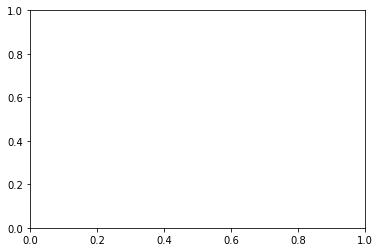

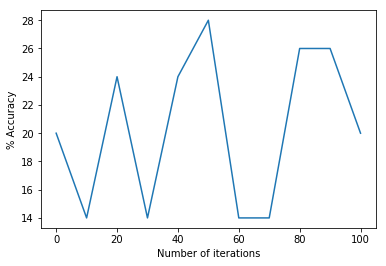

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(results_detail['5_sib_best32_10_50_101']['iteration'], results_detail['5_sib_best32_10_50_101']['%'])
plt.ylabel('% Accuracy')
plt.xlabel('Number of iterations')
plt.show()